In [1]:
"""
    author: Vetivert? 💐 
    created: 01/04/2025 @ 16:31:11
"""

'\n    author: Vetivert? 💐 \n    created: 01/04/2025 @ 16:31:11\n'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

from imblearn.over_sampling import SMOTE # type: ignore

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Masking # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.prefix_path import *

## LOAD Dataset: missing_2017 not removed

In [ ]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True) #indexes of 2019 data 
df.index = range(len(df)) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df.iloc[np.where(df == '8(nặng xin về)')] = 8

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(HEMATOMA_COLS[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(BLEEDING_COLS[0]), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.27, '2': 39.8, '3': 3.93}


## Strategy 1: dataset not balanced -- PLT index


In [ ]:
scaler = StandardScaler()

X = df.drop(MISSING_2017, axis=1).copy().loc[:, 'WBC1':'MPV 9']
X = X.apply(pd.to_numeric, errors='coerce')
Y = df['Diagnosis']
Y = Y.apply(pd.to_numeric, errors='coerce')

X = X.to_numpy()
X[np.isnan(X)] = 0
Y = Y.to_numpy()
X = scaler.fit_transform(X)

# X = X.reshape(X.shape[0], 9, 8)
Y = Y - 1

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=None)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
smote = SMOTE(sampling_strategy={2: int(0.4 * len(Y))}, random_state=42)  
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print('x_train shape: ', x_train.shape, 'y_train shape: ',  y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ',  y_test.shape)
uniques, counts = np.unique(y_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y_test), 2))))

X_train_resampled, x_val, x_test = \
    X_train_resampled.reshape(X_train_resampled.shape[0], 9, 8), \
        x_val.reshape(x_val.shape[0], 9, 8), \
            x_test.reshape(x_test.shape[0], 9, 8)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y),
    y=Y
)
class_weights_dict = dict(enumerate(class_weights))


x_train shape:  (284, 72) y_train shape:  (284,)
x_test shape:  (62, 72) y_test shape:  (62,)
percentage of classes:  {0: 56.45, 1: 40.32, 2: 3.23}


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4018 - loss: 2.8975 - val_accuracy: 0.1290 - val_loss: 2.2288
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4179 - loss: 1.2538 - val_accuracy: 0.2903 - val_loss: 1.4506
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4964 - loss: 1.0024 - val_accuracy: 0.4194 - val_loss: 1.2489
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6124 - loss: 0.7229 - val_accuracy: 0.4516 - val_loss: 1.2139
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6945 - loss: 0.5767 - val_accuracy: 0.5968 - val_loss: 0.9214
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7189 - loss: 0.5700 - val_accuracy: 0.6613 - val_loss: 0.8889
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7263 - loss: 0.5452 - val_accuracy: 0.5968 - val_loss: 0.8293
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7631 - loss: 0.3984 - val_accuracy: 0.

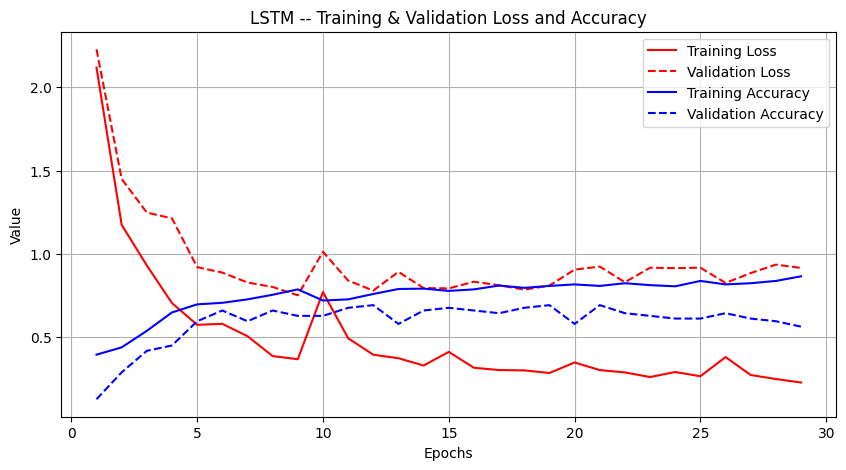

In [ ]:
# Define the BiLSTM model
model = Sequential([
    Input(shape=(9, 8)),  # Input shape: (timesteps, features)
    Masking(mask_value=-1.0),  # Ignores padding
    Bidirectional(LSTM(72, return_sequences=True)),  #, kernel_initializer='he_uniform'
    # Dropout(0.3),
    Bidirectional(LSTM(36)),  #, kernel_initializer='he_uniform'
    # Dropout(0.3),
    Dense(36, activation='relu'),
    Dense(3, activation='softmax')  # 3-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,  
    epochs=100,
    batch_size=16,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(patience=20)],
    class_weight=class_weights_dict  # handles imbalance
)

# Extract values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot both accuracy and loss
plt.figure(figsize=(10, 5))

# Left Y-axis: Loss
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'r--', label="Validation Loss")

# Right Y-axis: Accuracy
plt.plot(epochs, train_acc, 'b-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b--', label="Validation Accuracy")

# Labels & Legends
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("LSTM -- Training & Validation Loss and Accuracy")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [196]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5430 - loss: 0.9910
Test Accuracy: 0.5645


## LSTM for AST ALT

In [ ]:
scaler = StandardScaler()

# df = df.drop(['Bil TP7', 'Bil TT 7'], axis=1)
X = df.drop(MISSING_2017, axis=1).copy().loc[:, 'Glu1':'GGT9']
X = X.apply(pd.to_numeric, errors='coerce')
Y = df['Diagnosis']
Y = Y.apply(pd.to_numeric, errors='coerce')

X = X.to_numpy()
X[np.isnan(X)] = 0
Y = Y.to_numpy()
X = scaler.fit_transform(X)

# X = X.reshape(X.shape[0], 9, 8)
Y = Y - 1

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=None)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
smote = SMOTE(sampling_strategy={2: int(0.4 * len(Y))}, random_state=42)  
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print('x_train shape: ', x_train.shape, 'y_train shape: ',  y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ',  y_test.shape)
uniques, counts = np.unique(y_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y_test), 2))))

X_train_resampled, x_val, x_test = \
    X_train_resampled.reshape(X_train_resampled.shape[0], 9, 7), \
        x_val.reshape(x_val.shape[0], 9, 7), \
            x_test.reshape(x_test.shape[0], 9, 7)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y),
    y=Y
)
class_weights_dict = dict(enumerate(class_weights))


x_train shape:  (284, 63) y_train shape:  (284,)
x_test shape:  (62, 63) y_test shape:  (62,)
percentage of classes:  {0: 50.0, 1: 46.77, 2: 3.23}


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3436 - loss: 2.9737 - val_accuracy: 0.0323 - val_loss: 2.2245
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4002 - loss: 1.2213 - val_accuracy: 0.0645 - val_loss: 2.0170
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4054 - loss: 1.1060 - val_accuracy: 0.1290 - val_loss: 1.6093
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4787 - loss: 0.9920 - val_accuracy: 0.1452 - val_loss: 1.5014
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4872 - loss: 0.8961 - val_accuracy: 0.1613 - val_loss: 1.5799
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5472 - loss: 0.8488 - val_accuracy: 0.2097 - val_loss: 1.5341
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5680 - loss: 0.7957 - val_accuracy: 0.1935 - val_loss: 1.2739
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6259 - loss: 0.6478 - val_accuracy: 0.

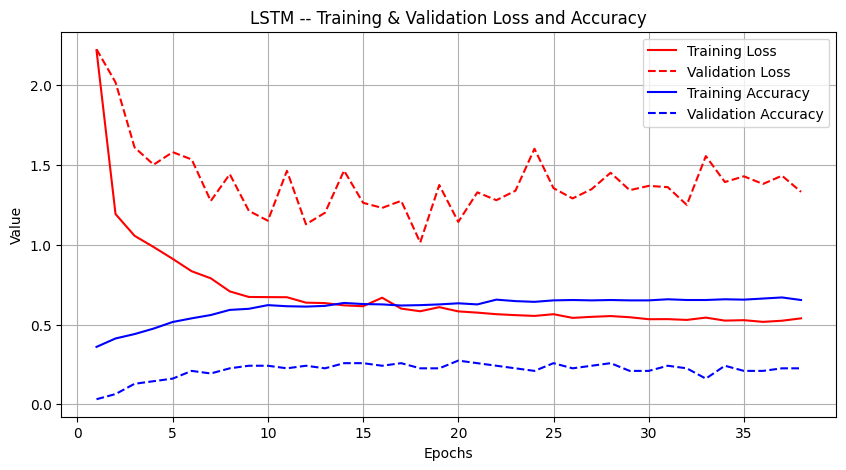

In [201]:
# Define the BiLSTM model
model = Sequential([
    Input(shape=(9, 7)),  # Input shape: (timesteps, features)
    Masking(mask_value=-1.0),  # Ignores padding
    Bidirectional(LSTM(72, return_sequences=True, kernel_initializer='he_uniform')),  
    # Dropout(0.3),
    Bidirectional(LSTM(36, kernel_initializer='he_uniform')),  
    # Dropout(0.3),
    Dense(36, activation='relu'),
    Dense(3, activation='softmax')  # 3-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,  
    epochs=100,
    batch_size=16,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(patience=20)],
    class_weight=class_weights_dict  # handles imbalance
)

# Extract values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot both accuracy and loss
plt.figure(figsize=(10, 5))

# Left Y-axis: Loss
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'r--', label="Validation Loss")

# Right Y-axis: Accuracy
plt.plot(epochs, train_acc, 'b-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b--', label="Validation Accuracy")

# Labels & Legends
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("LSTM -- Training & Validation Loss and Accuracy")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [202]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2443 - loss: 1.3199
Test Accuracy: 0.2258


In [ ]:
import shap

# Explainer for LSTM
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)